In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import rasterio
import shapely
import random
import os

from shapely.geometry import shape
from shapely.geometry import Point

import pystac_client
import planetary_computer as pc

import random
random.seed(10)

In [2]:
# accesing Azure storage using pystac client
URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = pystac_client.Client.open(URL)

# ********* CAMPUS POINT NAIP SCENE *********
itemid = 'ca_m_3411934_sw_11_060_20180722_20190209'
search = catalog.search(
    collections=["naip"],
    ids = itemid
)
item = list(search.get_items())[0]
# sign and open item
href = pc.sign(item.assets["image"].href)
ds = rasterio.open(href)
# we only need the image at this point to access the datasets crs

In [4]:
#fp = os.path.join(os.getcwd(),'aux_data','non_iceplant_vegetation/non_iceplant_vegetation.shp')
fp = os.path.join(os.getcwd(),'aux_data','trees/trees.shp')
polys = gpd.read_file(fp)

polys.to_crs(ds.crs,inplace=True)

In [5]:
polys['area'] = polys.geometry.apply(lambda p : p.area)
polys.sort_values(by='area',ascending=False,inplace=True)
polys.reset_index(drop=True,inplace=True)
polys['iceplant']=0
polys.head()

,id,geometry,area,iceplant
0,2,"POLYGON ((238155.522 3811276.831, 238163.326 3...",590.576486,0
1,0,"POLYGON ((238126.181 3811299.617, 238130.239 3...",522.228808,0
2,1,"POLYGON ((238105.268 3811214.403, 238112.135 3...",312.850129,0


<AxesSubplot:>

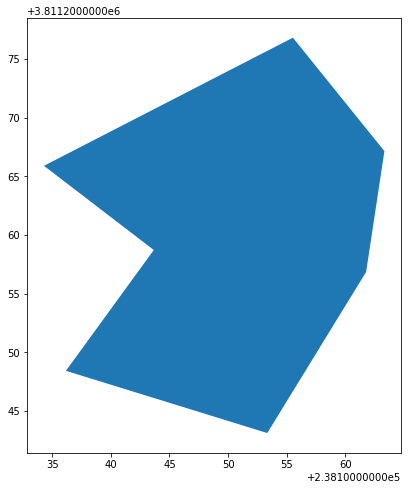

In [6]:
# pick biggest polygon
biggest = polys.filter(items=[0],axis=0).reset_index(drop=True)

fig, ax = plt.subplots()
fig.set_size_inches((8,8))
biggest.plot(ax=ax)

In [7]:
def random_pts_poly(number, polygon):
    points = []
    min_x, min_y, max_x, max_y = polygon.bounds
    i= 0
    while i < number:
        point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if polygon.contains(point):
            points.append(point)
            i += 1
    return points  

<AxesSubplot:>

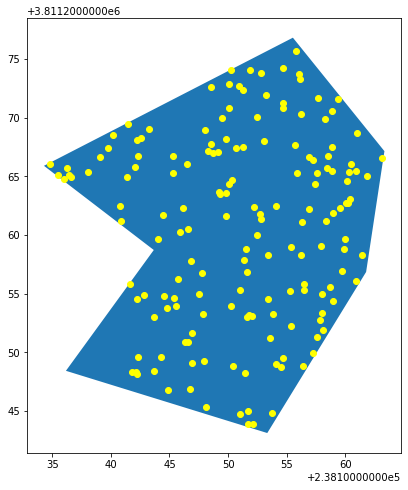

In [9]:
proportion = 0.1
# calculating how many pixels are there in the polygon (approx), by dividing the area of poly by area of a single pixel
pixels_in_poly = int(biggest.area/(ds.res[0]*ds.res[1])) 
N= int(pixels_in_poly * proportion)
# BEFORE N=25
# DEFINE NUMBER OF RANDOM POINTS TO BE SELECTED ON BIGGEST POLYGON
# the rest of the polygons will have a number of polygons proportional to their area

points = random_pts_poly(N,biggest['geometry'][0])
# ********** SIMPLIFY THIS ***************
geo_points = gpd.GeoDataFrame({'geometry':points},crs = polys.crs)
#geo_points['geometry']=points
#geo_points.set_crs(polys.crs,inplace=True)
# *******************************************************************

fig, ax = plt.subplots()
fig.set_size_inches((8,8))
biggest.plot(ax=ax)
geo_points.plot(ax=ax,color='yellow')

In [10]:
big_area = biggest['geometry'][0].area
polys['num_random_pts'] = polys.area.apply(lambda a : int(a/big_area*N))
polys.drop('area',axis=1,inplace=True)
#polys

In [11]:
samples = []
for i in range(0,polys.shape[0]):
    poly = polys['geometry'][i]
    N = polys['num_random_pts'][i]
    
    points = random_pts_poly(N,poly)
    sample = gpd.DataFrame({
        'geometry': pd.Series(points), 
        'iceplant':pd.Series(np.full(N,polys['iceplant'][i]))
                 })
    sample['xy']=sample.geometry.apply(lambda p :(p.x, p.y))
    
    data_generator = ds.sample(sample.xy)
    data = []
    for i in data_generator:
        data.append(i)
    data = np.vstack(data)
    data = pd.DataFrame(data, columns=['r','g','b','nifr'])
    
    sample = pd.concat([sample,data],axis=1)
    samples.append(sample)



/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [12]:
train_set = pd.concat(samples)
train_set['x']= train_set.geometry.apply(lambda p : p.x)
train_set['y']= train_set.geometry.apply(lambda p : p.y)
train_set.drop('xy',axis=1,inplace=True)
train_set.reset_index(drop=True,inplace=True)
train_set

,geometry,iceplant,r,g,b,nifr,x,y
0,POINT (238154.89939934976 3811251.861536609),0,30,41,62,25,238154.899399,3.811252e+06
1,POINT (238155.35035970793 3811252.3537978763),0,32,41,63,26,238155.350360,3.811252e+06
2,POINT (238153.33195766463 3811266.800670018),0,72,74,80,145,238153.331958,3.811267e+06
3,POINT (238146.55267626952 3811252.620114596),0,69,62,74,135,238146.552676,3.811253e+06
4,POINT (238152.13956707923 3811257.607136089),0,47,52,71,58,238152.139567,3.811258e+06
...,...,...,...,...,...,...,...,...
390,POINT (238111.65715664873 3811183.5731393895),0,62,68,83,77,238111.657157,3.811184e+06
391,POINT (238102.11970270815 3811182.1509996275),0,77,79,85,164,238102.119703,3.811182e+06
392,POINT (238110.8183550578 3811197.325979317),0,67,65,76,142,238110.818355,3.811197e+06
393,POINT (238110.8621339487 3811185.670170691),0,61,62,77,119,238110.862134,3.811186e+06


In [13]:
train_set = train_set[['geometry','x','y','r','g','b','nifr','iceplant']]
train_set

,geometry,x,y,r,g,b,nifr,iceplant
0,POINT (238154.89939934976 3811251.861536609),238154.899399,3.811252e+06,30,41,62,25,0
1,POINT (238155.35035970793 3811252.3537978763),238155.350360,3.811252e+06,32,41,63,26,0
2,POINT (238153.33195766463 3811266.800670018),238153.331958,3.811267e+06,72,74,80,145,0
3,POINT (238146.55267626952 3811252.620114596),238146.552676,3.811253e+06,69,62,74,135,0
4,POINT (238152.13956707923 3811257.607136089),238152.139567,3.811258e+06,47,52,71,58,0
...,...,...,...,...,...,...,...,...
390,POINT (238111.65715664873 3811183.5731393895),238111.657157,3.811184e+06,62,68,83,77,0
391,POINT (238102.11970270815 3811182.1509996275),238102.119703,3.811182e+06,77,79,85,164,0
392,POINT (238110.8183550578 3811197.325979317),238110.818355,3.811197e+06,67,65,76,142,0
393,POINT (238110.8621339487 3811185.670170691),238110.862134,3.811186e+06,61,62,77,119,0


In [17]:
fp = os.path.join(os.getcwd(),'aux_data','trainset_trees','trainset_trees.csv')
train_set.to_csv(fp)

In [15]:
# *** TO DO: save shapefile, not only csv
# fp = os.path.join(os.getcwd(),'aux_data','trainset_trees','trainset_trees.shp')
# train_set.to_file(fp)

In [20]:
#copy = train_set.drop(['geometry','x','y'],axis=1)
copy.drop_duplicates(subset = ['r','g','b','nifr'])

,r,g,b,nifr,iceplant
0,163,144,116,183,0
1,114,103,95,140,0
2,59,67,69,137,0
3,132,117,107,138,0
4,146,126,107,165,0
...,...,...,...,...,...
193340,34,43,64,48,0
193341,84,95,105,89,0
193342,82,86,87,113,0
193343,88,89,93,120,0


In [21]:
193345 - 145982

47363